In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

os.chdir('../..')
os.getcwd()

import warnings
warnings.filterwarnings('ignore')

## Load all r square files from superposition analysis

In [2]:
file_dir = '03_results/models/'
# get all subdirectories starting with 'largesim_ae'
subdirs = [x for x in os.listdir(file_dir) if os.path.isdir(file_dir + x) and x.startswith('largesim_ae')]

In [3]:
r_squares = []
for subdir in subdirs:
    # get the r2 score
    try:
        r2 = pd.read_csv(file_dir + subdir + '/r_squares.csv')
        # give it column names
        r2.columns = ['variable', 'R^2']
        
        # get the latent dimension
        r2['latent'] = int(subdir.split('_latent-')[-1].split('_')[0])
        # get the depth
        r2['depth'] = int(subdir.split('_depth-')[-1].split('_')[0])
        # get the width
        r2['width'] = subdir.split('_width-')[-1].split('_')[0]
        # get the seed
        r2['seed'] = int(subdir.split('_seed-')[-1].split('_')[0])
        # create a name
        r2['name'] = subdir
        r2['name_short'] = subdir.split('_latent-')[-1].split('_')[0] + '-' + subdir.split('_depth-')[-1].split('_')[0] + '-' + ('n' if subdir.split('_width-')[-1].split('_')[0] == 'narrow' else 'w')

        # also load the history and add the validation loss
        history = pd.read_csv(file_dir + subdir + '/history.csv')
        r2['val_loss'] = history['val_loss'].iloc[-1]
        
        r_squares.append(r2)
    except:
        print('Error with ' + subdir)
        continue
# concatenate all r2 scores
r_squares = pd.concat(r_squares)
r_squares = r_squares.reset_index(drop=True)
# change the names of the variables to the last part of the string
r_squares['variable'] = r_squares['variable'].str.split('_').str[-1]
# sort the df first by latent dimension, then by depth, then by width
r_squares = r_squares.sort_values(by=['latent', 'depth', 'width', 'seed'])

r_squares.head()

Error with largesim_ae_latent-1000_depth-6_width-wide_seed-0


,variable,R^2,latent,depth,width,seed,name,name_short,val_loss
126,y,0.670699,20,2,narrow,0,largesim_ae_latent-20_depth-2_width-narrow_seed-0,20-2-n,7.161949
127,x0,-0.137217,20,2,narrow,0,largesim_ae_latent-20_depth-2_width-narrow_seed-0,20-2-n,7.161949
128,x1,0.019795,20,2,narrow,0,largesim_ae_latent-20_depth-2_width-narrow_seed-0,20-2-n,7.161949
129,x2,0.529748,20,2,narrow,0,largesim_ae_latent-20_depth-2_width-narrow_seed-0,20-2-n,7.161949
130,ct,0.323950,20,2,narrow,0,largesim_ae_latent-20_depth-2_width-narrow_seed-0,20-2-n,7.161949


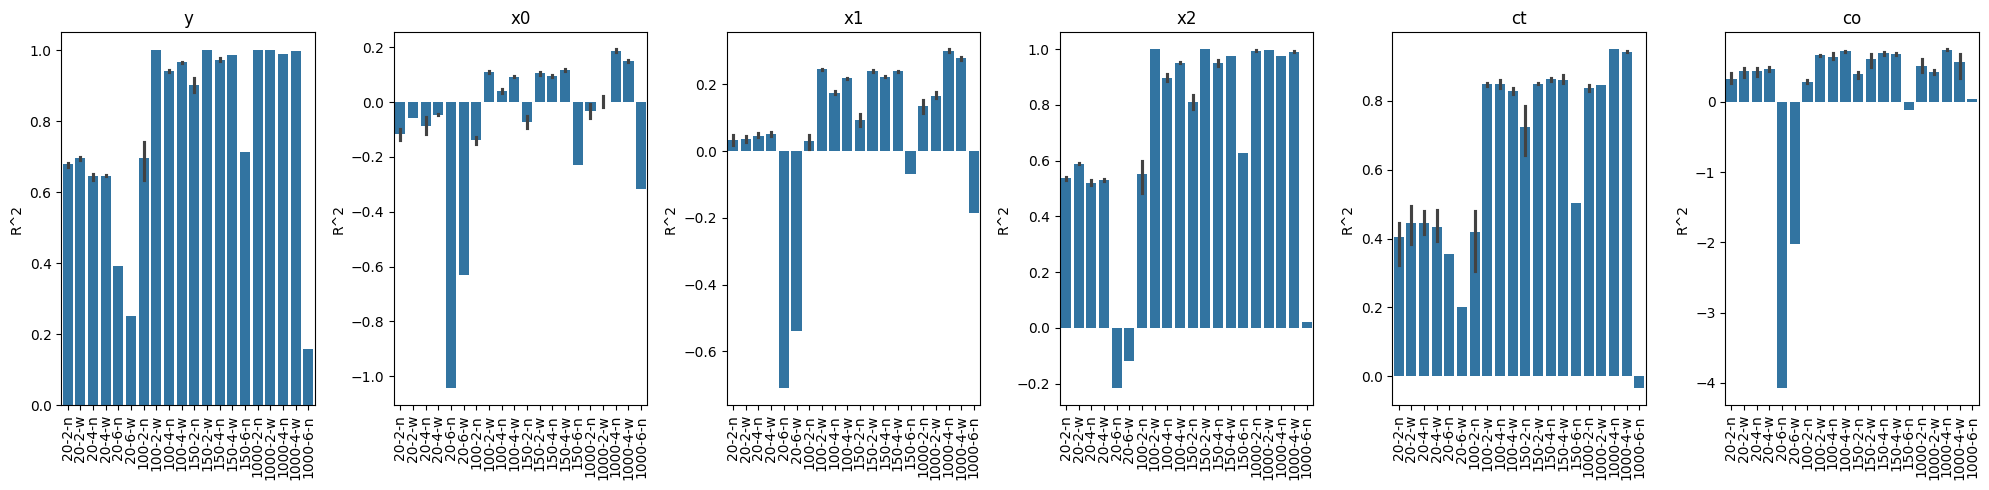

In [5]:
# make a figure with 6 subplots in one row showing barplots of the r2 scores
variable_names = r_squares['variable'].unique()

fig, axs = plt.subplots(1, 6, figsize=(20, 5))
for i, ax in enumerate(axs):
    df_temp = r_squares[r_squares['variable'] == variable_names[i]]
    sns.barplot(data=df_temp, x='name_short', y='R^2', ax=ax)
    ax.set_title(variable_names[i])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_xlabel('')
    ax.set_ylabel('R^2')
plt.tight_layout()
plt.show()

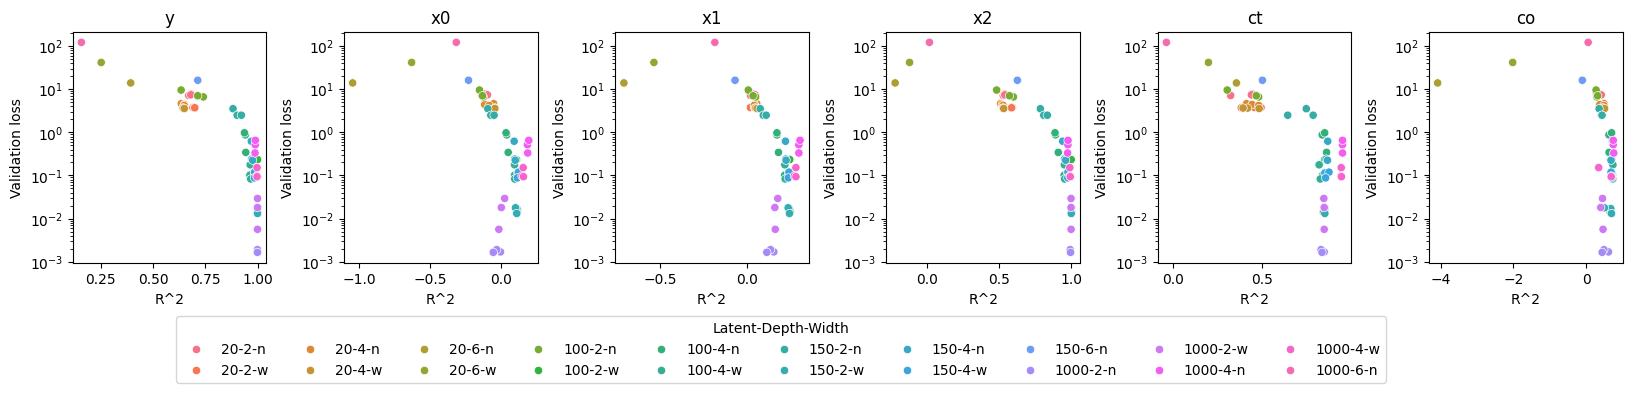

In [6]:
# plot val loss against R2

fig, axs = plt.subplots(1, 6, figsize=(20, 3))
# add spacing
fig.subplots_adjust(wspace=0.4)
for i, ax in enumerate(axs):
    df_temp = r_squares[r_squares['variable'] == variable_names[i]]
    sns.scatterplot(data=df_temp, x='R^2', y='val_loss', hue='name_short', ax=ax)
    ax.set_title(variable_names[i])
    ax.set_xlabel('R^2')
    ax.set_ylabel('Validation loss')
    ax.set_yscale('log')
    if i == 0:
        # set the legend at the bottom with 10 columns
        ax.legend(loc='upper left', bbox_to_anchor=(0.5, -0.2), ncol=10, title='Latent-Depth-Width')
    else:
        ax.get_legend().remove()
plt.tight_layout()
plt.show()

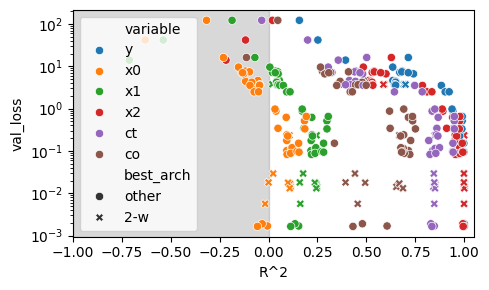

In [4]:
# plot val loss against R2
r_squares['best_arch'] = ['2-w' if '2-w' in x else 'other' for x in r_squares['name_short']]

fig, axs = plt.subplots(1, 1, figsize=(5, 3))
plt.axvspan(-1.0, 0, color='grey', alpha=0.3)
sns.scatterplot(data=r_squares, y='val_loss', x='R^2', hue='variable', style='best_arch')
plt.xlim(-1, 1.05)
plt.yscale('log')
plt.tight_layout()
plt.show()

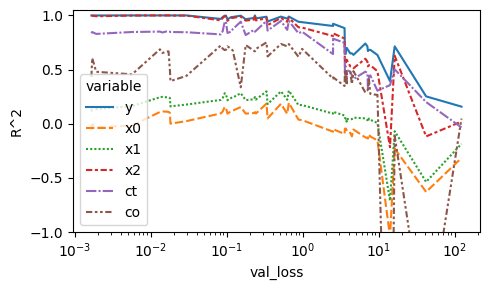

In [18]:
# plot val loss against R2

fig, axs = plt.subplots(1, 1, figsize=(5, 3))
sns.lineplot(data=r_squares, x='val_loss', y='R^2', hue='variable', style='variable')
plt.ylim(-1, 1.05)
plt.xscale('log')
plt.tight_layout()
plt.show()

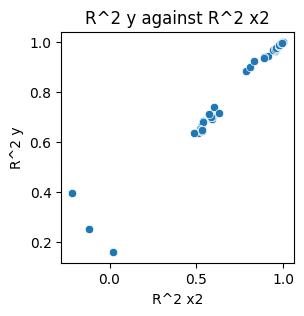

In [7]:
# plot y against x2

y_values = r_squares[r_squares['variable'] == 'y']['R^2'].values
x_values = r_squares[r_squares['variable'] == 'x2']['R^2'].values

plt.figure(figsize=(3, 3))
sns.scatterplot(x=x_values, y=y_values)
plt.xlabel('R^2 x2')
plt.ylabel('R^2 y')
plt.title('R^2 y against R^2 x2')
plt.show()

### Results (Y)

A very narrow bottleneck generally decreases the superpositions (latent 20).

Given a latent dim close to the manifold dimension, superpositions of Y are much less compressed. But here we clearly see a difference between the model complexity. Two narrow layers lead to a strong decrease compared to 2-w, 4-n, and 4-w.

6 layers seem generally to be problematic in training. So going very deep is not a good idea.

It looks like 2 wide layers generally were most reliable (in Y superposition recovery)

### Results (X)

X variables not directly connected to Y are extremely compressed / not recoverable. X2 however is well recovered in superpositions again for bottlenecks close to the manifold dimension or larger, especially for 2 wide layers.

### Results (CT and CO)

For CT we see a different trend. Here recovery is best for a large bottleneck (1000). Otherwise 2-4 layers for 100-150 latent (4 narrow layers seem to be marginally best) do well but are around 0.8.

CO (the noise variable) generally does very badly.

## first SAE analysis

In [2]:
file_dir = '03_results/models/largesim_ae_latent-20_depth-2_width-wide_seed-0/sae/'
# get all subdirectories starting with 'largesim_ae'
filenames = [x for x in os.listdir(file_dir) if os.path.isfile(file_dir + x) and x.startswith('losses')]

In [3]:
losses = None
for filename in filenames:
    if losses is None:
        losses = pd.read_csv(file_dir + filename)
        losses['model'] = filename.split('losses_')[1].split('.csv')[0]
    else:
        temp = pd.read_csv(file_dir + filename)
        temp['model'] = filename.split('losses_')[1].split('.csv')[0]
        losses = pd.concat([losses, temp])

losses['scaling_factor'] = losses['model'].str.split('x_').str[0]
losses['l1_weight'] = losses['model'].str.split('_l1w').str[1].str.split('_').str[0]
losses['lr'] = losses['model'].str.split('_lr').str[1]
# change the name of the first column
losses.columns = ['epoch'] + list(losses.columns[1:])

losses.head()

,epoch,loss,val_loss,model,scaling_factor,l1_weight,lr
0,0,32789.563471,24987.104603,200x_l1w0.01_lr1e-06,200,0.01,1e-06
1,1,20095.260282,16266.067618,200x_l1w0.01_lr1e-06,200,0.01,1e-06
2,2,13364.329905,10954.151120,200x_l1w0.01_lr1e-06,200,0.01,1e-06
3,3,9033.865565,7388.056548,200x_l1w0.01_lr1e-06,200,0.01,1e-06
4,4,6060.051356,4901.335987,200x_l1w0.01_lr1e-06,200,0.01,1e-06


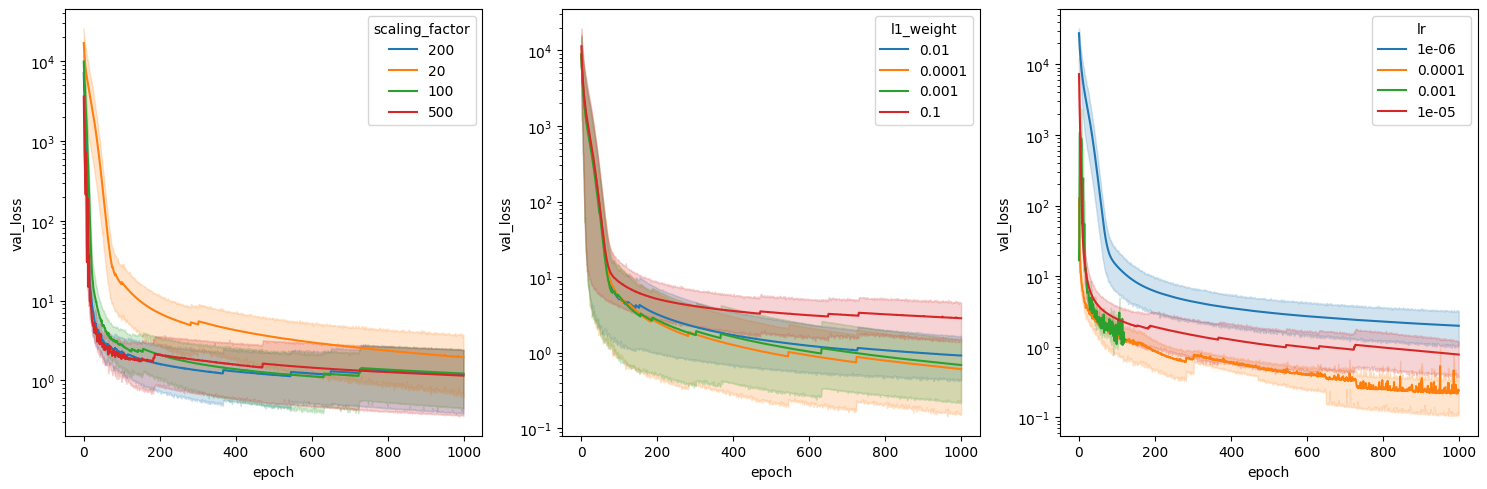

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.lineplot(data=losses, x='epoch', y='val_loss', hue='scaling_factor', ax=ax[0])
ax[0].set_yscale('log')
sns.lineplot(data=losses, x='epoch', y='val_loss', hue='l1_weight', ax=ax[1])
ax[1].set_yscale('log')
sns.lineplot(data=losses, x='epoch', y='val_loss', hue='lr', ax=ax[2])
ax[2].set_yscale('log')
plt.tight_layout()
plt.show()

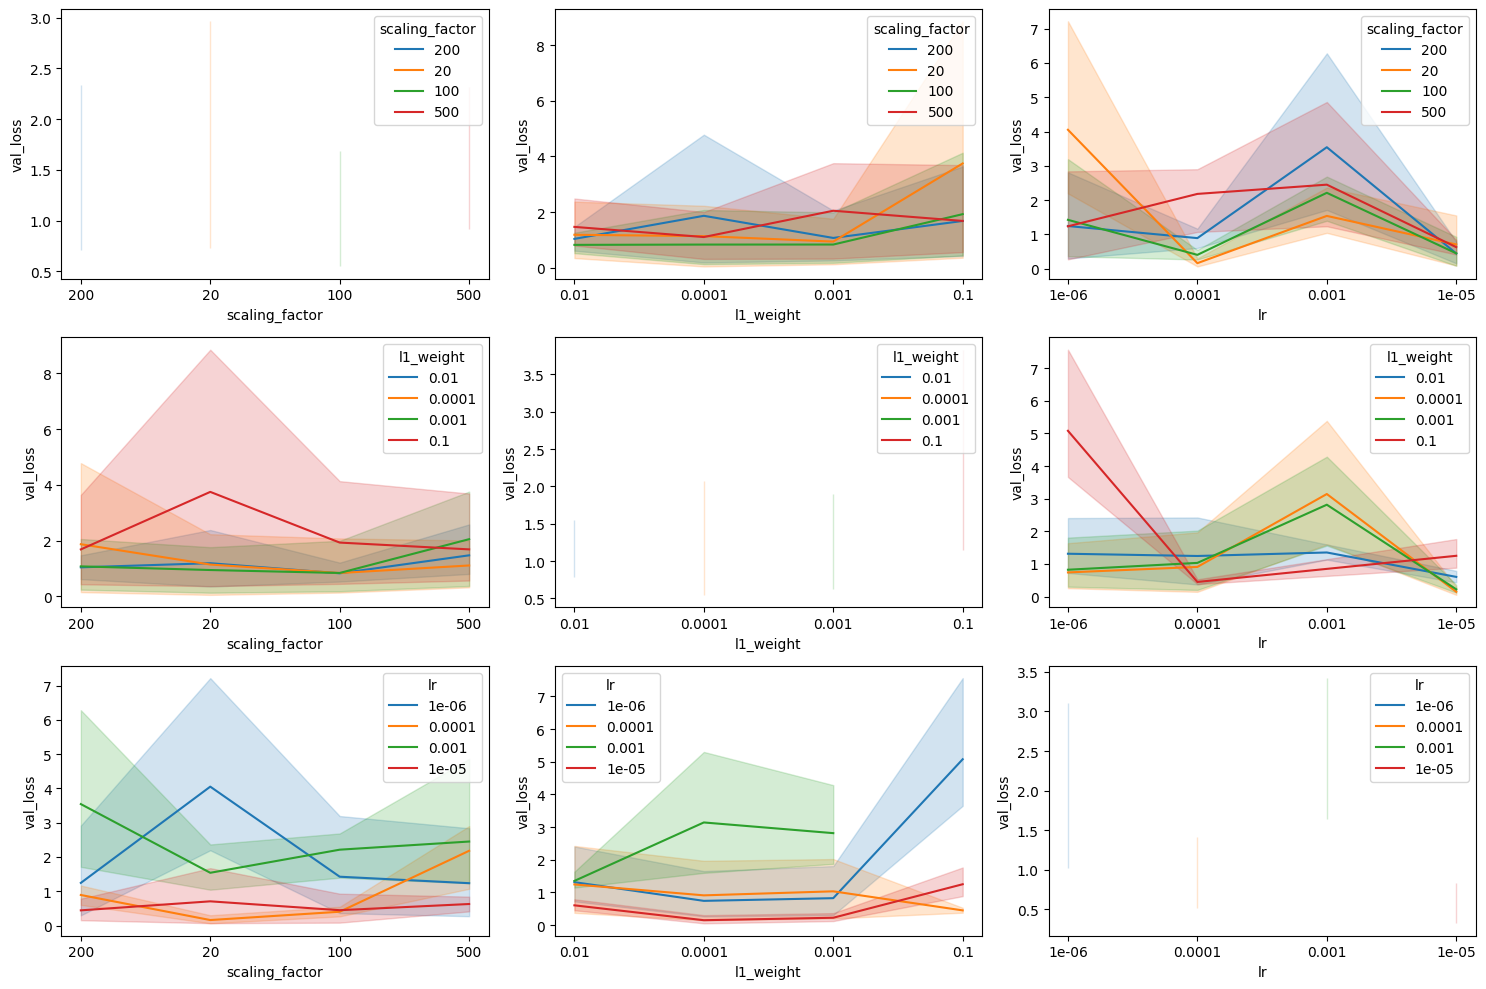

In [5]:
losses_final = []
for model_name in losses['model'].unique():
    temp = losses[losses['model'] == model_name]
    losses_final.append(temp.iloc[-1])
losses_final = pd.concat(losses_final, axis=1).T

fig, ax = plt.subplots(3, 3, figsize=(15, 10))
sns.lineplot(data=losses_final, x='scaling_factor', y='val_loss', hue='scaling_factor', ax=ax[0,0])
sns.lineplot(data=losses_final, x='l1_weight', y='val_loss', hue='scaling_factor', ax=ax[0,1])
sns.lineplot(data=losses_final, x='lr', y='val_loss', hue='scaling_factor', ax=ax[0,2])
sns.lineplot(data=losses_final, x='scaling_factor', y='val_loss', hue='l1_weight', ax=ax[1,0])
sns.lineplot(data=losses_final, x='l1_weight', y='val_loss', hue='l1_weight', ax=ax[1,1])
sns.lineplot(data=losses_final, x='lr', y='val_loss', hue='l1_weight', ax=ax[1,2])
sns.lineplot(data=losses_final, x='scaling_factor', y='val_loss', hue='lr', ax=ax[2,0])
sns.lineplot(data=losses_final, x='l1_weight', y='val_loss', hue='lr', ax=ax[2,1])
sns.lineplot(data=losses_final, x='lr', y='val_loss', hue='lr', ax=ax[2,2])
plt.tight_layout()
plt.show()

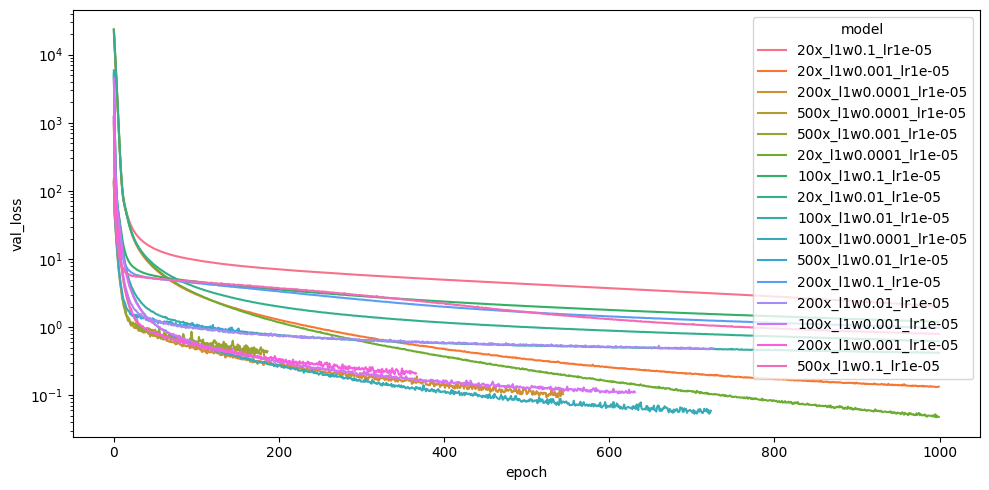

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.lineplot(data=losses[losses['lr'] == '1e-05'], x='epoch', y='val_loss', hue='model', ax=ax)
ax.set_yscale('log')
plt.tight_layout()
plt.show()

## SAE analysis

In [4]:
results_dir = '03_results/models/'
latent_dims = [20, 100, 150]
depth = 2
width = 'wide'
seed = 0

losses = None
for latent_dim in latent_dims:
    file_dir = results_dir + 'largesim_ae_latent-' + str(latent_dim) + '_depth-' + str(depth) + '_width-' + width + '_seed-' + str(seed) + '/sae/'
    # get all subdirectories starting with 'largesim_ae'
    filenames = [x for x in os.listdir(file_dir) if os.path.isfile(file_dir + x) and x.startswith('losses')]

    for filename in filenames:
        if losses is None:
            losses = pd.read_csv(file_dir + filename)
            losses['model'] = filename.split('losses_')[1].split('.csv')[0]
            losses['latent_dim'] = latent_dim
        else:
            temp = pd.read_csv(file_dir + filename)
            temp['model'] = filename.split('losses_')[1].split('.csv')[0]
            temp['latent_dim'] = latent_dim
            losses = pd.concat([losses, temp])

    losses['scaling_factor'] = losses['model'].str.split('x_').str[0]
    losses['l1_weight'] = losses['model'].str.split('_l1w').str[1].str.split('_').str[0]
    losses['lr'] = losses['model'].str.split('_lr').str[1]
    # change the name of the first column

losses.columns = ['epoch'] + list(losses.columns[1:])
losses = losses[losses['lr'] == '1e-05']
losses.head()

,epoch,loss,val_loss,model,latent_dim,scaling_factor,l1_weight,lr
0,0,31209.331271,23199.706215,20x_l1w0.1_lr1e-05,20,20,0.1,1e-05
1,1,17758.563230,13392.050942,20x_l1w0.1_lr1e-05,20,20,0.1,1e-05
2,2,10196.317771,7619.693718,20x_l1w0.1_lr1e-05,20,20,0.1,1e-05
3,3,5796.789931,4317.863878,20x_l1w0.1_lr1e-05,20,20,0.1,1e-05
4,4,3273.890257,2419.316536,20x_l1w0.1_lr1e-05,20,20,0.1,1e-05


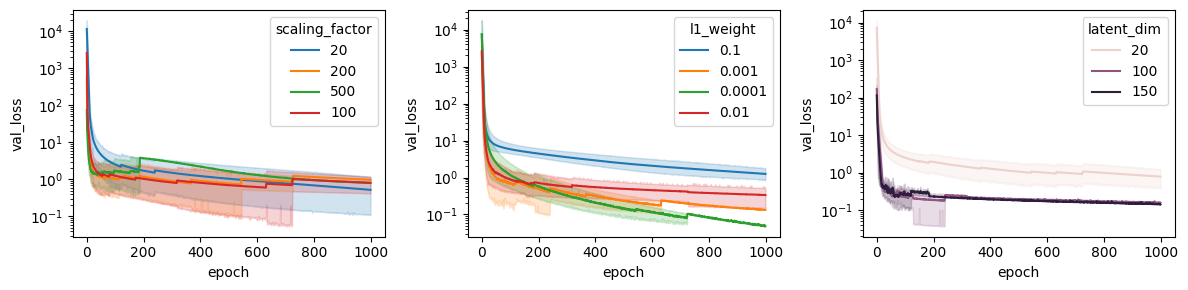

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))
sns.lineplot(data=losses, x='epoch', y='val_loss', hue='scaling_factor', ax=ax[0])
ax[0].set_yscale('log')
sns.lineplot(data=losses, x='epoch', y='val_loss', hue='l1_weight', ax=ax[1])
ax[1].set_yscale('log')
sns.lineplot(data=losses, x='epoch', y='val_loss', hue='latent_dim', ax=ax[2])
ax[2].set_yscale('log')
plt.tight_layout()
plt.show()

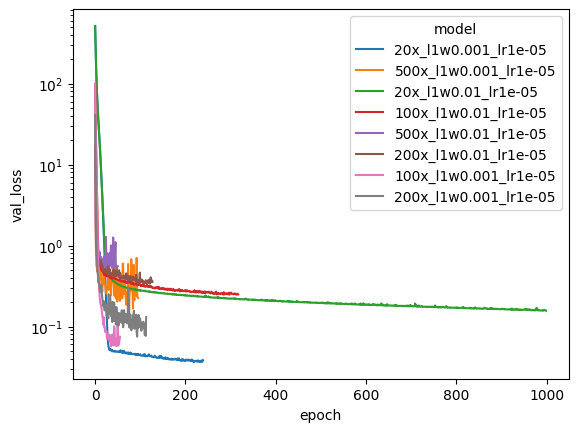

In [8]:
sns.lineplot(data=losses[(losses['latent_dim'] == 100)], x='epoch', y='val_loss', hue='model')
plt.yscale('log')
plt.show()

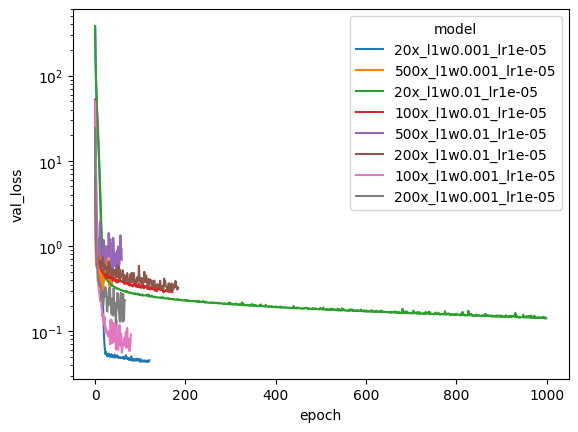

In [9]:
sns.lineplot(data=losses[(losses['latent_dim'] == 150)], x='epoch', y='val_loss', hue='model')
plt.yscale('log')
plt.show()

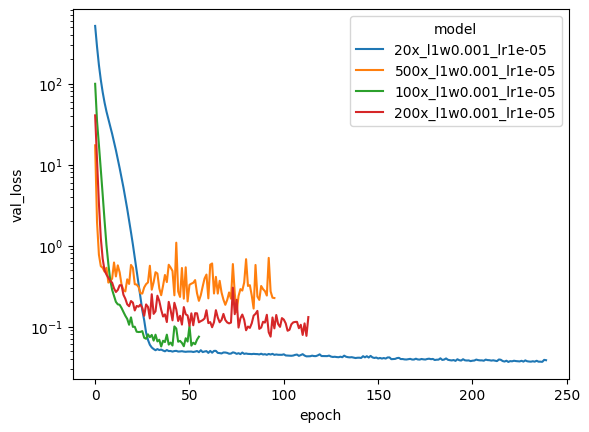

In [6]:
sns.lineplot(data=losses[(losses['latent_dim'] == 100) & (losses['l1_weight'] == '0.001')], x='epoch', y='val_loss', hue='model')
plt.yscale('log')
plt.show()

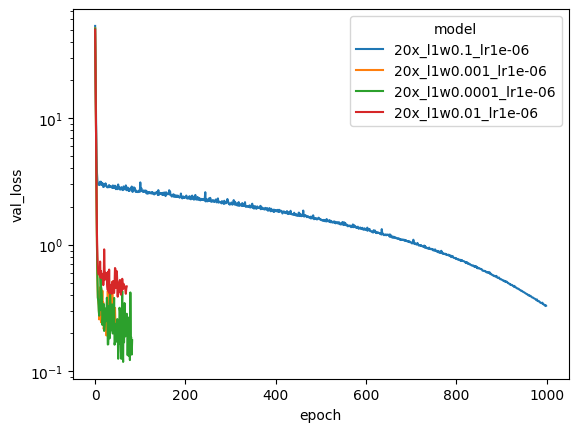

In [19]:
sns.lineplot(data=losses[(losses['latent_dim'] == 150) & (losses['scaling_factor'] == '20')], x='epoch', y='val_loss', hue='model')
plt.yscale('log')
plt.show()

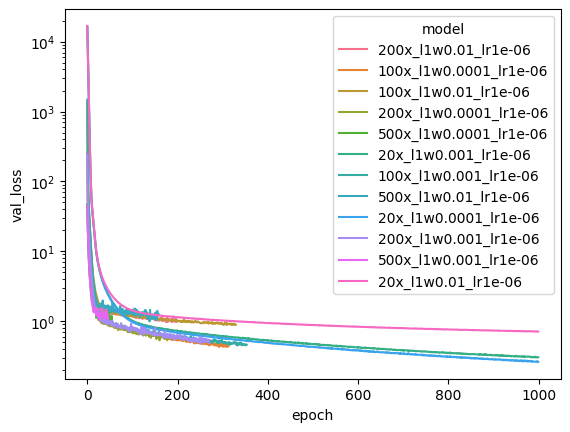

In [15]:
sns.lineplot(data=losses[(losses['latent_dim'] == 20)], x='epoch', y='val_loss', hue='model')
plt.yscale('log')
plt.show()

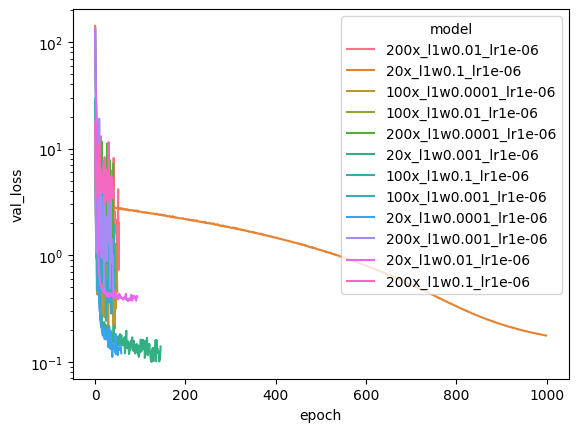

In [18]:
sns.lineplot(data=losses[(losses['latent_dim'] == 100)], x='epoch', y='val_loss', hue='model')
plt.yscale('log')
plt.show()

### A scaling factor of 20 and an l1 weight of 0.001 seem to perform well for all latent dimensions

# Look into feature programs

In [2]:
import torch
import random

# set a random seed
seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

dev_id = 1
device = torch.device(f'cuda:{dev_id}' if torch.cuda.is_available() else 'cpu')

In [3]:
complexity = 'high'
n_samples = 100000
data_dir = '/home/vschuste/data/simulation/'

for seed in range(10):
    temp_y = torch.load(data_dir+'large_{}-complexity_rs{}_y.pt'.format(complexity, seed), weights_only=False)
    temp_x0 = torch.load(data_dir+'large_{}-complexity_rs{}_x0.pt'.format(complexity, seed), weights_only=False)
    temp_x1 = torch.load(data_dir+'large_{}-complexity_rs{}_x1.pt'.format(complexity, seed), weights_only=False)
    temp_x2 = torch.load(data_dir+'large_{}-complexity_rs{}_x2.pt'.format(complexity, seed), weights_only=False)
    temp_ct = torch.load(data_dir+'large_{}-complexity_rs{}_ct.pt'.format(complexity, seed), weights_only=False)
    temp_cov = torch.load(data_dir+'large_{}-complexity_rs{}_co.pt'.format(complexity, seed), weights_only=False)
    if seed == 0:
        rna_counts = temp_y
        x0 = temp_x0
        x1 = temp_x1
        x2 = temp_x2
        ct = temp_ct
        co = temp_cov
    else:
        rna_counts = torch.cat((rna_counts, temp_y), dim=0)
        x0 = torch.cat((x0, temp_x0), dim=0)
        x1 = torch.cat((x1, temp_x1), dim=0)
        x2 = torch.cat((x2, temp_x2), dim=0)
        ct = torch.cat((ct, temp_ct), dim=0)
        co = torch.cat((co, temp_cov), dim=0)
# limit to the training data
n_samples_train = int(n_samples*0.9)
rna_counts = rna_counts[:n_samples_train]
x0 = x0[:n_samples_train]
x1 = x1[:n_samples_train]
x2 = x2[:n_samples_train]
ct = ct[:n_samples_train]
co = co[:n_samples_train]
# also make this faster by taking every 10th sample
rna_counts = rna_counts[::20]
x0 = x0[::20]
x1 = x1[::20]
x2 = x2[::20]
ct = ct[::20]
co = co[::20]

In [4]:
rna_counts.shape

torch.Size([4500, 20000])

In [4]:
results_dir = '03_results/models/'
latent_dim = 150
depth = 2
width = 'wide'
seed = 0

ae_dir = results_dir + 'largesim_ae_latent-' + str(latent_dim) + '_depth-' + str(depth) + '_width-' + width + '_seed-' + str(seed) + '/'
file_dir = ae_dir + 'sae/'
# get all subdirectories starting with 'largesim_ae'
filenames = [x for x in os.listdir(file_dir) if os.path.isfile(file_dir + x) and x.startswith('sae')]
# only keep the ones that are for lr 1e-6
filenames = [x for x in filenames if 'lr1e-06' in x]

# load the encoder
encoder = torch.load(ae_dir +  'encoder.pth', weights_only=False).to(device)
encoder.eval()
# get embeddings
reps = encoder(rna_counts.to(device)).detach()

file_dir = results_dir + 'largesim_ae_latent-' + str(latent_dim) + '_depth-' + str(depth) + '_width-' + width + '_seed-' + str(seed) + '/sae/'
filename = 'sae_100x_l1w0.001_lr1e-05.pth'

sae_model = torch.load(file_dir + filename, weights_only=False).to(device)

chunksize = 1000
activations = []
for i in range(0, reps.shape[0], chunksize):
    reps_reconstructed, activations_chunk = sae_model(reps[i:i+chunksize].to(device))
    activations.append(activations_chunk)
    del reps_reconstructed
activations = torch.cat(activations, dim=0)

In [85]:
encoder

Encoder2(
  (layers): ModuleList(
    (0): Linear(in_features=20000, out_features=5075, bias=True)
    (1): Dropout(p=0.0, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=5075, out_features=150, bias=True)
  )
)

In [6]:
activations = activations.cpu().detach()

In [13]:
activations.shape

torch.Size([4500, 15000])

### something like an AUC of recovering the regulation matrix

In [7]:
# keep only the live activations
dead_neurons = (activations == 0).sum(dim=0) == activations.shape[0]

In [8]:
activations = activations[:, ~dead_neurons]
print('Removed {} dead neurons'.format(dead_neurons.sum()))

Removed 3151 dead neurons


In [9]:
import tqdm

cos_sim = torch.zeros((activations.shape[1], rna_counts.shape[1]))
for i in tqdm.tqdm(range(rna_counts.shape[1])):
    cos_sim[:,i] = torch.nn.functional.cosine_similarity(activations, rna_counts[:,i].unsqueeze(1), dim=0).detach().cpu()

sae_feature_for_y = []
for i in range(rna_counts.shape[1]):
    sae_feature_for_y.append(torch.argmax(cos_sim[:,i]).item())

100%|██████████| 20000/20000 [41:34<00:00,  8.02it/s] 


In [10]:
# save the cos_sims
torch.save(cos_sim, file_dir + 'cos_sim_activ_y.pt')

In [ ]:
cos_sim = torch.load(file_dir + 'cos_sim_activ_y.pt')

In [11]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)
random.seed(0)
# adjacency matrices (binary)
p_xy = 0.1
xy = torch.tensor(np.random.binomial(1, p_xy, (100, 20000))).float()

In [12]:
import scipy.stats as stats

def binomial_test(n_study, n_hit, n_c, n):
    p_c = n_c / n # this is the expected probability of a hit
    results = stats.binomtest(n_hit, n_study, p_c)
    over_under = '+' if n_hit > (n_study * p_c) else '-'
    fold_enrichment = n_hit / (n_study * p_c)
    fdr = (n_study - n_hit) / n_study
    expected = n_study * p_c
    return n_hit, results.pvalue, expected, fold_enrichment, fdr, n_study, n_c

In [ ]:
# lets do the same thing but with 95th percentile of cos_sim instead of max

percentiles = [1,10,20,30,40,50,60,70,80,90,95,99]

for perc in percentiles:
    perc_99_cos_sim = torch.tensor(np.percentile(cos_sim.numpy().flatten(), perc))
    print(f'{perc}th percentile:', perc_99_cos_sim)

    pseudo_connectivity = torch.zeros((activations.shape[1], rna_counts.shape[1]))
    for i in range(rna_counts.shape[1]):
        pseudo_connectivity[:,i] = torch.where(cos_sim[:,i] >= perc_99_cos_sim, 1, 0)
    # drop all the features that are not used (or just redundant)
    used_features = torch.where(pseudo_connectivity.sum(dim=1) > 0)[0]
    pseudo_connectivity = pseudo_connectivity[used_features,:]

    # save the file
    #torch.save(pseudo_connectivity, file_dir + 'pseudo_connectivity_99p.pt')

    # perform the binomial test for each feature-X pair in terms of genes
    connectivity_test = torch.zeros((pseudo_connectivity.shape[0], xy.shape[0], 7))
    n = pseudo_connectivity.shape[1]
    import multiprocessing as mp
    pool = mp.Pool(mp.cpu_count())
    for i in range(pseudo_connectivity.shape[0]):
        n_study = int(pseudo_connectivity[i,:].sum().item())
        connectivity_test[i, :, :] = torch.tensor(pool.starmap(binomial_test, [(n_study, int((xy[j,:] * pseudo_connectivity[i,:]).sum().item()), int(xy[j,:].sum().item()), n) for j in range(xy.shape[0])]))

    # for each feature, get the best matching X

    best_matches_feat2X_idx = torch.argmax(connectivity_test[:,:,0], dim=1)
    best_matches_feat2X_nhit = torch.max(connectivity_test[:,:,0], dim=1).values
    best_matches_feat2X_pval = connectivity_test[torch.arange(connectivity_test.shape[0]), best_matches_feat2X_idx, 1]
    best_matches_feat2X_expected = connectivity_test[torch.arange(connectivity_test.shape[0]), best_matches_feat2X_idx, 2]
    best_matches_feat2X_fold_enrichment = connectivity_test[torch.arange(connectivity_test.shape[0]), best_matches_feat2X_idx, 3]
    best_matches_feat2X_fdr = connectivity_test[torch.arange(connectivity_test.shape[0]), best_matches_feat2X_idx, 4]
    best_matches_feat2X_nfeat = connectivity_test[torch.arange(connectivity_test.shape[0]), best_matches_feat2X_idx, 5]
    best_matches_feat2X_nX = connectivity_test[torch.arange(connectivity_test.shape[0]), best_matches_feat2X_idx, 6]

    # make this a dataframe
    best_matches_feat2X = pd.DataFrame({
        'feature': used_features,
        'X': best_matches_feat2X_idx,
        'n_hit': best_matches_feat2X_nhit,
        'pval': best_matches_feat2X_pval,
        'expected': best_matches_feat2X_expected,
        'fold_enrichment': best_matches_feat2X_fold_enrichment,
        'fdr': best_matches_feat2X_fdr,
        'n_feat': best_matches_feat2X_nfeat,
        'n_X': best_matches_feat2X_nX
    })
    # remove all rows with 0 hits
    best_matches_feat2X = best_matches_feat2X[best_matches_feat2X['n_hit'] > 0]

    best_matches_feat2X['n_wrong'] = best_matches_feat2X['n_feat'] + best_matches_feat2X['n_X'] - (2 * best_matches_feat2X['n_hit'])
    best_matches_feat2X['fraction_covered'] = best_matches_feat2X['n_hit'] / best_matches_feat2X['n_X']
    best_matches_feat2X['fraction_covered_feat'] = best_matches_feat2X['n_hit'] / best_matches_feat2X['n_feat']

    best_matches_feat2X.sort_values(by='n_wrong', ascending=True)

    # for each X, get the maximum fraction covered
    df_temp = pd.DataFrame({
        'X': best_matches_feat2X['X'],
        'max_fraction_covered': best_matches_feat2X['fraction_covered'],
        'percentile': perc
    })
    if perc == 1:
        df_results = df_temp
    else:
        df_results = pd.concat([df_results, df_temp])

1th percentile: tensor(0.0555, dtype=torch.float64)
10th percentile: tensor(0.7227, dtype=torch.float64)
20th percentile: tensor(0.7737, dtype=torch.float64)
30th percentile: tensor(0.7986, dtype=torch.float64)
40th percentile: tensor(0.8166, dtype=torch.float64)
50th percentile: tensor(0.8317, dtype=torch.float64)
60th percentile: tensor(0.8454, dtype=torch.float64)
70th percentile: tensor(0.8589, dtype=torch.float64)
80th percentile: tensor(0.8735, dtype=torch.float64)
90th percentile: tensor(0.8917, dtype=torch.float64)
95th percentile: tensor(0.9051, dtype=torch.float64)
99th percentile: tensor(0.9267, dtype=torch.float64)


In [15]:
# save the results
df_results.to_csv(file_dir + 'best_matches_feat2X.csv', index=False)

In [6]:
# read the file
df_results = pd.read_csv(file_dir + 'best_matches_feat2X.csv')

In [7]:
df_results

,X,max_fraction_covered,percentile
0,52,1.000000,1
1,52,1.000000,1
2,52,1.000000,1
3,52,1.000000,1
4,52,1.000000,1
...,...,...,...
134527,87,0.007925,99
134528,93,0.075630,99
134529,18,0.001016,99
134530,66,0.008885,99


In [30]:
# for each percentile, calculate the max max_fraction_covered per X
# if there are missing X values, fill them with 0

df_results_2 = []
for perc in percentiles:
    temp = df_results[df_results['percentile'] == perc]
    temp = temp.groupby('X').max().reset_index()
    temp['percentile'] = perc
    # now go through all unique X values and fill in the missing ones (range(0,100))
    x_in_temp = temp['X'].values
    x_not_in_temp = list(set(range(100)) - set(x_in_temp))
    print(len(x_not_in_temp))
    # add the missing values
    temp2 = pd.DataFrame({
        'X': x_not_in_temp,
        'max_fraction_covered': [0] * len(x_not_in_temp),
        'percentile': [perc] * len(x_not_in_temp)
    })
    temp = pd.concat([temp, temp2])
    df_results_2.append(temp)
# save the results
df_results_2 = pd.concat(df_results_2)
df_results_2.to_csv(file_dir + 'best_matches_feat2X_max_filled.csv', index=False)

69
69
46
44
45
44
43
41
42
41
37
0


In [5]:
df_results_2 = pd.read_csv(file_dir + 'best_matches_feat2X_max_filled.csv')

In [23]:
df_results_2

,X,max_fraction_covered,percentile
0,15.0,0.001030,1.0
1,28.0,0.996124,1.0
2,31.0,0.999038,1.0
3,44.0,0.986335,1.0
4,49.0,0.995618,1.0
...,...,...,...
95,95.0,0.166002,99.0
96,96.0,0.222898,99.0
97,97.0,0.148260,99.0
98,98.0,0.114531,99.0


In [25]:
# print the both the average max_fraction_covered and the number of features that are covered for each X (threshold 0.1)
df_results_2.groupby(['percentile']).mean().sort_values(by='max_fraction_covered', ascending=False)

,X,max_fraction_covered
percentile,,
30.0,49.5,0.525077
20.0,49.5,0.513693
50.0,49.5,0.513027
40.0,49.5,0.511279
60.0,49.5,0.490733
70.0,49.5,0.446152
80.0,49.5,0.389587
90.0,49.5,0.288616
10.0,49.5,0.287789


In [29]:
for perc in percentiles:
    temp = df_results_2[df_results_2['percentile'] == perc]
    print(f'Percentile {perc}', temp[temp['max_fraction_covered'] > 0].shape[0])

Percentile 1 31
Percentile 10 31
Percentile 20 54
Percentile 30 56
Percentile 40 55
Percentile 50 56
Percentile 60 57
Percentile 70 59
Percentile 80 58
Percentile 90 59
Percentile 95 63
Percentile 99 100


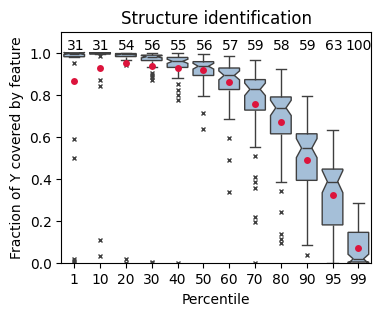

In [84]:
# remove all zero values and plot a boxplot of the max_fraction_covered vs the percentile
df_results_3 = df_results_2[df_results_2['max_fraction_covered'] > 0]
# make percentile integer
df_results_3['percentile'] = df_results_3['percentile'].astype(int)

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
# scientific boxplot
sns.boxplot(data=df_results_3, x='percentile', y='max_fraction_covered', ax=ax, notch=True, fliersize=3, flierprops={"marker": "x"}, boxprops={"facecolor": (.3, .5, .7, .5)})
# over this plot a red dot for the mean
sns.stripplot(data=df_results_3.groupby('percentile').mean().reset_index(), x='percentile', y='max_fraction_covered', color='crimson', size=5, ax=ax)
# above each box print the number of Xs covered as text
for i, perc in enumerate(percentiles):
    n_x = df_results_3[df_results_3['percentile'] == percentiles[i]].shape[0]
    if n_x > 99: 
        spacer = 0.5
    else:
        spacer = 0.3
    ax.text(i-spacer, 1.07, f'{n_x}', verticalalignment='top')
plt.ylim(0, 1.1)
plt.xlabel('Percentile')
plt.ylabel('Fraction of Y covered by feature')
plt.title('Structure identification')
#plt.tight_layout()
# export as pdf
plt.savefig('03_results/figures/sim_structure_identification.pdf', bbox_inches='tight')
plt.show()

In [77]:
df_results_3.groupby('percentile').mean().reset_index()

,percentile,X,max_fraction_covered
0,1,74.000000,0.865143
1,10,69.354839,0.928351
2,20,69.240741,0.951284
3,30,70.035714,0.937637
4,40,69.836364,0.929598
5,50,70.660714,0.916120
6,60,70.122807,0.860935
7,70,69.101695,0.756189
8,80,70.103448,0.671702
9,90,68.898305,0.489180


### previous tests

In [13]:
import tqdm

cos_sim = torch.zeros((activations.shape[1], rna_counts.shape[1]))
for i in tqdm.tqdm(range(rna_counts.shape[1])):
    cos_sim[:,i] = torch.nn.functional.cosine_similarity(activations, rna_counts[:,i].unsqueeze(1), dim=0).detach().cpu()

sae_feature_for_y = []
for i in range(rna_counts.shape[1]):
    sae_feature_for_y.append(torch.argmax(cos_sim[:,i]).item())

100%|██████████| 20000/20000 [28:43<00:00, 11.61it/s]


In [14]:
pseudo_connectivity = torch.zeros((activations.shape[1], rna_counts.shape[1]))
for i in range(rna_counts.shape[1]):
    pseudo_connectivity[sae_feature_for_y[i], i] = 1
# drop all the features that are not used (or just redundant)
used_features = torch.unique(torch.tensor(sae_feature_for_y))
pseudo_connectivity = pseudo_connectivity[used_features,:]

In [15]:
pseudo_connectivity.shape

torch.Size([1189, 20000])

In [16]:
# save the file
torch.save(pseudo_connectivity, file_dir + 'pseudo_connectivity.pt')

In [17]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)
random.seed(0)
# adjacency matrices (binary)
p_xy = 0.1
xy = torch.tensor(np.random.binomial(1, p_xy, (100, 20000))).float()

In [57]:
# calculate the 95th percentile
print('min, mean, max:', torch.min(xy), torch.mean(xy), torch.max(xy))
perc_95 = np.percentile(xy, 95)
print('95th percentile:', perc_95)

min, mean, max: tensor(0.) tensor(0.1000) tensor(1.)
95th percentile: 1.0


In [49]:
# perform the binomial test for each feature-X pair in terms of genes

import scipy.stats as stats

def binomial_test(n_study, n_hit, n_c, n):
    p_c = n_c / n # this is the expected probability of a hit
    results = stats.binomtest(n_hit, n_study, p_c)
    over_under = '+' if n_hit > (n_study * p_c) else '-'
    fold_enrichment = n_hit / (n_study * p_c)
    fdr = (n_study - n_hit) / n_study
    expected = n_study * p_c
    return n_hit, results.pvalue, expected, fold_enrichment, fdr, n_study, n_c

connectivity_test = torch.zeros((pseudo_connectivity.shape[0], xy.shape[0], 7))
n = pseudo_connectivity.shape[1]
import multiprocessing as mp
pool = mp.Pool(mp.cpu_count())
for i in range(pseudo_connectivity.shape[0]):
    n_study = int(pseudo_connectivity[i,:].sum().item())
    connectivity_test[i, :, :] = torch.tensor(pool.starmap(binomial_test, [(n_study, int((xy[j,:] * pseudo_connectivity[i,:]).sum().item()), int(xy[j,:].sum().item()), n) for j in range(xy.shape[0])]))
    #for j in range(xy.shape[0]):
    #    n_study = int(pseudo_connectivity[i,:].sum().item())
    #    n_hit = int((xy[j,:] * pseudo_connectivity[i,:]).sum().item())
    #    n_c = int(xy[j,:].sum().item())
    #    connectivity_test[i, j, 0], connectivity_test[i, j, 1], connectivity_test[i, j, 2], connectivity_test[i, j, 3] = binomial_test(n_study, n_hit, n_c, n)

In [51]:
# for each feature, get the best matching X

best_matches_feat2X_idx = torch.argmax(connectivity_test[:,:,0], dim=1)
best_matches_feat2X_nhit = torch.max(connectivity_test[:,:,0], dim=1).values
best_matches_feat2X_pval = connectivity_test[torch.arange(connectivity_test.shape[0]), best_matches_feat2X_idx, 1]
best_matches_feat2X_expected = connectivity_test[torch.arange(connectivity_test.shape[0]), best_matches_feat2X_idx, 2]
best_matches_feat2X_fold_enrichment = connectivity_test[torch.arange(connectivity_test.shape[0]), best_matches_feat2X_idx, 3]
best_matches_feat2X_fdr = connectivity_test[torch.arange(connectivity_test.shape[0]), best_matches_feat2X_idx, 4]
best_matches_feat2X_nfeat = connectivity_test[torch.arange(connectivity_test.shape[0]), best_matches_feat2X_idx, 5]
best_matches_feat2X_nX = connectivity_test[torch.arange(connectivity_test.shape[0]), best_matches_feat2X_idx, 6]

# make this a dataframe
best_matches_feat2X = pd.DataFrame({
    'feature': used_features,
    'X': best_matches_feat2X_idx,
    'n_hit': best_matches_feat2X_nhit,
    'pval': best_matches_feat2X_pval,
    'expected': best_matches_feat2X_expected,
    'fold_enrichment': best_matches_feat2X_fold_enrichment,
    'fdr': best_matches_feat2X_fdr,
    'n_feat': best_matches_feat2X_nfeat,
    'n_X': best_matches_feat2X_nX
})
# remove all rows with 0 hits
best_matches_feat2X = best_matches_feat2X[best_matches_feat2X['n_hit'] > 0]

In [54]:
best_matches_feat2X['n_wrong'] = best_matches_feat2X['n_feat'] + best_matches_feat2X['n_X'] - (2 * best_matches_feat2X['n_hit'])

best_matches_feat2X.sort_values(by='n_wrong', ascending=True)

,feature,X,n_hit,pval,expected,fold_enrichment,fdr,n_feat,n_X,n_wrong
1069,7207,82,151.0,0.000000e+00,21.705601,6.956730,0.337719,228.0,1904.0,1830.0
707,4936,94,123.0,0.000000e+00,14.565000,8.444902,0.180000,150.0,1942.0,1846.0
877,6073,82,29.0,6.679276e-26,3.141600,9.230965,0.121212,33.0,1904.0,1879.0
18,131,82,39.0,2.749420e-27,5.331200,7.315426,0.303571,56.0,1904.0,1882.0
633,4389,58,6.0,1.684419e-05,0.756000,7.936508,0.250000,8.0,1890.0,1886.0
...,...,...,...,...,...,...,...,...,...,...
899,6230,52,20.0,9.387998e-16,2.641250,7.572172,0.200000,25.0,2113.0,2098.0
596,4142,52,6.0,8.792113e-05,0.950850,6.310143,0.333333,9.0,2113.0,2110.0
211,1318,52,1.0,1.056500e-01,0.105650,9.465216,0.000000,1.0,2113.0,2112.0
1182,7968,52,18.0,7.647265e-08,4.437300,4.056521,0.571429,42.0,2113.0,2119.0


In [59]:
# lets do the same thing but with 95th percentile of cos_sim instead of max

perc_95_cos_sim = torch.tensor(np.percentile(cos_sim.numpy().flatten(), 95))
print('95th percentile:', perc_95_cos_sim)

95th percentile: tensor(0.7833, dtype=torch.float64)


In [60]:
pseudo_connectivity = torch.zeros((activations.shape[1], rna_counts.shape[1]))
for i in range(rna_counts.shape[1]):
    pseudo_connectivity[:,i] = torch.where(cos_sim[:,i] >= perc_95_cos_sim, 1, 0)
# drop all the features that are not used (or just redundant)
used_features = torch.where(pseudo_connectivity.sum(dim=1) > 0)[0]
pseudo_connectivity = pseudo_connectivity[used_features,:]

In [62]:
# save the file
torch.save(pseudo_connectivity, file_dir + 'pseudo_connectivity_95p.pt')

In [63]:
# perform the binomial test for each feature-X pair in terms of genes

import scipy.stats as stats

def binomial_test(n_study, n_hit, n_c, n):
    p_c = n_c / n # this is the expected probability of a hit
    results = stats.binomtest(n_hit, n_study, p_c)
    over_under = '+' if n_hit > (n_study * p_c) else '-'
    fold_enrichment = n_hit / (n_study * p_c)
    fdr = (n_study - n_hit) / n_study
    expected = n_study * p_c
    return n_hit, results.pvalue, expected, fold_enrichment, fdr, n_study, n_c

connectivity_test = torch.zeros((pseudo_connectivity.shape[0], xy.shape[0], 7))
n = pseudo_connectivity.shape[1]
import multiprocessing as mp
pool = mp.Pool(mp.cpu_count())
for i in range(pseudo_connectivity.shape[0]):
    n_study = int(pseudo_connectivity[i,:].sum().item())
    connectivity_test[i, :, :] = torch.tensor(pool.starmap(binomial_test, [(n_study, int((xy[j,:] * pseudo_connectivity[i,:]).sum().item()), int(xy[j,:].sum().item()), n) for j in range(xy.shape[0])]))

In [65]:
# for each feature, get the best matching X

best_matches_feat2X_idx = torch.argmax(connectivity_test[:,:,0], dim=1)
best_matches_feat2X_nhit = torch.max(connectivity_test[:,:,0], dim=1).values
best_matches_feat2X_pval = connectivity_test[torch.arange(connectivity_test.shape[0]), best_matches_feat2X_idx, 1]
best_matches_feat2X_expected = connectivity_test[torch.arange(connectivity_test.shape[0]), best_matches_feat2X_idx, 2]
best_matches_feat2X_fold_enrichment = connectivity_test[torch.arange(connectivity_test.shape[0]), best_matches_feat2X_idx, 3]
best_matches_feat2X_fdr = connectivity_test[torch.arange(connectivity_test.shape[0]), best_matches_feat2X_idx, 4]
best_matches_feat2X_nfeat = connectivity_test[torch.arange(connectivity_test.shape[0]), best_matches_feat2X_idx, 5]
best_matches_feat2X_nX = connectivity_test[torch.arange(connectivity_test.shape[0]), best_matches_feat2X_idx, 6]

# make this a dataframe
best_matches_feat2X = pd.DataFrame({
    'feature': used_features,
    'X': best_matches_feat2X_idx,
    'n_hit': best_matches_feat2X_nhit,
    'pval': best_matches_feat2X_pval,
    'expected': best_matches_feat2X_expected,
    'fold_enrichment': best_matches_feat2X_fold_enrichment,
    'fdr': best_matches_feat2X_fdr,
    'n_feat': best_matches_feat2X_nfeat,
    'n_X': best_matches_feat2X_nX
})
# remove all rows with 0 hits
best_matches_feat2X = best_matches_feat2X[best_matches_feat2X['n_hit'] > 0]

best_matches_feat2X['n_wrong'] = best_matches_feat2X['n_feat'] + best_matches_feat2X['n_X'] - (2 * best_matches_feat2X['n_hit'])
best_matches_feat2X['fraction_covered'] = best_matches_feat2X['n_hit'] / best_matches_feat2X['n_X']
best_matches_feat2X['fraction_covered_feat'] = best_matches_feat2X['n_hit'] / best_matches_feat2X['n_feat']

best_matches_feat2X.sort_values(by='n_wrong', ascending=True)

,feature,X,n_hit,pval,expected,fold_enrichment,fdr,n_feat,n_X,n_wrong,fraction_covered,fraction_covered_feat
2078,4091,93,974.0,0.000000e+00,125.223701,7.778080,0.213247,1238.0,2023.0,1313.0,0.481463,0.786753
1002,1889,94,741.0,0.000000e+00,92.342102,8.024508,0.220820,951.0,1942.0,1411.0,0.381565,0.779180
1521,2938,97,634.0,0.000000e+00,72.280350,8.771402,0.130315,729.0,1983.0,1444.0,0.319718,0.869685
436,803,96,855.0,0.000000e+00,117.847801,7.255121,0.283920,1194.0,1974.0,1458.0,0.433131,0.716080
3815,7450,91,639.0,0.000000e+00,75.537750,8.459347,0.153642,755.0,2001.0,1478.0,0.319340,0.846358
...,...,...,...,...,...,...,...,...,...,...,...,...
3116,6124,80,2012.0,7.059406e-10,1762.288330,1.141697,0.882291,17093.0,2062.0,15131.0,0.975752,0.117709
801,1468,75,1969.0,1.052254e-05,1790.267578,1.099836,0.886277,17314.0,2068.0,15444.0,0.952128,0.113723
775,1413,87,1991.0,8.246730e-08,1773.085815,1.122901,0.886643,17564.0,2019.0,15601.0,0.986132,0.113357
2520,4959,80,2030.0,1.948519e-07,1816.518921,1.117522,0.884783,17619.0,2062.0,15621.0,0.984481,0.115217


In [66]:
# lets do the same thing but with 95th percentile of cos_sim instead of max

perc_99_cos_sim = torch.tensor(np.percentile(cos_sim.numpy().flatten(), 99))
print('95th percentile:', perc_99_cos_sim)

pseudo_connectivity = torch.zeros((activations.shape[1], rna_counts.shape[1]))
for i in range(rna_counts.shape[1]):
    pseudo_connectivity[:,i] = torch.where(cos_sim[:,i] >= perc_99_cos_sim, 1, 0)
# drop all the features that are not used (or just redundant)
used_features = torch.where(pseudo_connectivity.sum(dim=1) > 0)[0]
pseudo_connectivity = pseudo_connectivity[used_features,:]

# save the file
torch.save(pseudo_connectivity, file_dir + 'pseudo_connectivity_99p.pt')

# perform the binomial test for each feature-X pair in terms of genes
connectivity_test = torch.zeros((pseudo_connectivity.shape[0], xy.shape[0], 7))
n = pseudo_connectivity.shape[1]
import multiprocessing as mp
pool = mp.Pool(mp.cpu_count())
for i in range(pseudo_connectivity.shape[0]):
    n_study = int(pseudo_connectivity[i,:].sum().item())
    connectivity_test[i, :, :] = torch.tensor(pool.starmap(binomial_test, [(n_study, int((xy[j,:] * pseudo_connectivity[i,:]).sum().item()), int(xy[j,:].sum().item()), n) for j in range(xy.shape[0])]))

# for each feature, get the best matching X

best_matches_feat2X_idx = torch.argmax(connectivity_test[:,:,0], dim=1)
best_matches_feat2X_nhit = torch.max(connectivity_test[:,:,0], dim=1).values
best_matches_feat2X_pval = connectivity_test[torch.arange(connectivity_test.shape[0]), best_matches_feat2X_idx, 1]
best_matches_feat2X_expected = connectivity_test[torch.arange(connectivity_test.shape[0]), best_matches_feat2X_idx, 2]
best_matches_feat2X_fold_enrichment = connectivity_test[torch.arange(connectivity_test.shape[0]), best_matches_feat2X_idx, 3]
best_matches_feat2X_fdr = connectivity_test[torch.arange(connectivity_test.shape[0]), best_matches_feat2X_idx, 4]
best_matches_feat2X_nfeat = connectivity_test[torch.arange(connectivity_test.shape[0]), best_matches_feat2X_idx, 5]
best_matches_feat2X_nX = connectivity_test[torch.arange(connectivity_test.shape[0]), best_matches_feat2X_idx, 6]

# make this a dataframe
best_matches_feat2X = pd.DataFrame({
    'feature': used_features,
    'X': best_matches_feat2X_idx,
    'n_hit': best_matches_feat2X_nhit,
    'pval': best_matches_feat2X_pval,
    'expected': best_matches_feat2X_expected,
    'fold_enrichment': best_matches_feat2X_fold_enrichment,
    'fdr': best_matches_feat2X_fdr,
    'n_feat': best_matches_feat2X_nfeat,
    'n_X': best_matches_feat2X_nX
})
# remove all rows with 0 hits
best_matches_feat2X = best_matches_feat2X[best_matches_feat2X['n_hit'] > 0]

best_matches_feat2X['n_wrong'] = best_matches_feat2X['n_feat'] + best_matches_feat2X['n_X'] - (2 * best_matches_feat2X['n_hit'])
best_matches_feat2X['fraction_covered'] = best_matches_feat2X['n_hit'] / best_matches_feat2X['n_X']
best_matches_feat2X['fraction_covered_feat'] = best_matches_feat2X['n_hit'] / best_matches_feat2X['n_feat']

best_matches_feat2X.sort_values(by='n_wrong', ascending=True)

95th percentile: tensor(0.8461, dtype=torch.float64)


,feature,X,n_hit,pval,expected,fold_enrichment,fdr,n_feat,n_X,n_wrong,fraction_covered,fraction_covered_feat
21,53,94,623.0,0.0,72.922096,8.543364,0.170439,751.0,1942.0,1447.0,0.320803,0.829561
865,2836,91,815.0,0.0,117.858902,6.915049,0.308149,1178.0,2001.0,1549.0,0.407296,0.691851
2263,7297,94,580.0,0.0,78.845200,7.356186,0.285714,812.0,1942.0,1594.0,0.298661,0.714286
2172,6972,96,899.0,0.0,140.450104,6.400850,0.368236,1423.0,1974.0,1599.0,0.455420,0.631764
789,2578,94,363.0,0.0,38.257401,9.488360,0.078680,394.0,1942.0,1610.0,0.186921,0.921320
...,...,...,...,...,...,...,...,...,...,...,...,...
1872,6124,80,1517.0,0.0,970.480286,1.563143,0.838840,9413.0,2062.0,8441.0,0.735694,0.161160
483,1468,94,1829.0,0.0,1006.441528,1.817294,0.823541,10365.0,1942.0,8649.0,0.941813,0.176459
1499,4959,80,1612.0,0.0,1056.156372,1.526289,0.842640,10244.0,2062.0,9082.0,0.781765,0.157360
467,1413,87,1707.0,0.0,1087.433350,1.569751,0.841534,10772.0,2019.0,9377.0,0.845468,0.158466


# evaluate the analysis

In [34]:
# load the evaluation metrics

results_dir = '03_results/reports/files/sim2L_sae_metrics_pearson_latent-'
latents = [20, 100, 150]

metrics = []
for latent in latents:
    metrics.append(pd.read_csv(results_dir + str(latent) + '.csv'))
metrics = pd.concat(metrics)
metrics = metrics.reset_index(drop=True)

In [36]:
def transform_str_to_avg(x):
    items = [y for y in x.strip('[]').split(' ')]
    # remove all '' elements
    items = [x for x in items if x != '']
    # transform to float
    items = np.asarray([float(x) for x in items])
    return np.max(items)

In [37]:
metrics['highest_corr_x0'] = [transform_str_to_avg(x) for x in metrics['highest_corr_x0'].values]
metrics['highest_corr_x1'] = [transform_str_to_avg(x) for x in metrics['highest_corr_x1'].values]
metrics['highest_corr_x2'] = [transform_str_to_avg(x) for x in metrics['highest_corr_x2'].values]
metrics['highest_corr_ct'] = [transform_str_to_avg(x) for x in metrics['highest_corr_ct'].values]
metrics['highest_corr_co'] = [transform_str_to_avg(x) for x in metrics['highest_corr_co'].values]

In [38]:
metrics

,latent_dim,hidden_factor,lr,l1_weight,n_activation_features,avg_active_hidden_units,n_unique,n_redundant,n_per_y,highest_corr_y,n_per_x0,highest_corr_x0,n_per_x1,highest_corr_x1,n_per_x2,highest_corr_x2,n_per_ct,highest_corr_ct,n_per_co,highest_corr_co
0,20,200,0.00001,0.001,4000,2094.000222,3997,3997,0.0,NaN,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,0.171427,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,0.235889,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,0.861516,[0],0.490732,[0],0.354628
1,20,500,0.00001,0.001,10000,5063.366889,9995,9995,0.0,NaN,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,0.170467,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,0.254648,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,0.841765,[0],-0.555667,[0],0.390950
2,20,100,0.00001,0.001,2000,1102.120889,1996,1996,0.0,NaN,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,0.129040,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,0.220565,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,0.852334,[0],-0.459877,[0],0.318578
3,20,20,0.00001,0.001,400,269.349778,399,399,0.0,NaN,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,0.127200,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,0.226871,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,0.758473,[0],-0.467351,[0],0.331460
4,20,200,0.00001,0.001,4000,2094.000222,3997,3997,0.0,NaN,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,0.171427,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,0.235889,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,0.861516,[0],0.490732,[0],0.354628
5,20,500,0.00001,0.001,10000,5063.366889,9995,9995,0.0,NaN,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,0.170467,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,0.254648,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,0.841765,[0],-0.555667,[0],0.390950
6,20,100,0.00001,0.001,2000,1102.120889,1996,1996,0.0,NaN,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,0.129040,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,0.220565,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,0.852334,[0],-0.459877,[0],0.318578
7,20,20,0.00001,0.001,400,269.349778,399,399,0.0,NaN,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,0.127200,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,0.226871,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,0.758473,[0],-0.467351,[0],0.331460
8,100,200,0.00001,0.001,20000,13961.524889,15570,15570,0.0,NaN,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,0.179568,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,0.424269,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,0.721758,[0],-0.540752,[0],0.637200
9,100,500,0.00001,0.001,50000,30040.088444,39020,39020,0.0,NaN,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,0.185641,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,0.435018,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,0.850158,[0],-0.541470,[0],0.640575


In [39]:
metrics_corr = metrics[['latent_dim', 'n_activation_features', 'highest_corr_x0', 'highest_corr_x1', 'highest_corr_x2', 'highest_corr_ct', 'highest_corr_co']]
# transform into long format to get highest correlation per variable
metrics_corr = pd.melt(metrics_corr, id_vars=['latent_dim', 'n_activation_features'], var_name='variable', value_name='highest_corr')
metrics_corr = metrics_corr.sort_values(by=['latent_dim', 'variable'])
metrics_corr.head()

,latent_dim,n_activation_features,variable,highest_corr
96,20,4000,highest_corr_co,0.354628
97,20,10000,highest_corr_co,0.390950
98,20,2000,highest_corr_co,0.318578
99,20,400,highest_corr_co,0.331460
100,20,4000,highest_corr_co,0.354628


In [43]:
# rename the variables (keep the last part of the string)
metrics_corr['variable'] = metrics_corr['variable'].str.split('_').str[-1]
metrics_corr

,latent_dim,n_activation_features,variable,highest_corr
96,20,4000,co,0.354628
97,20,10000,co,0.390950
98,20,2000,co,0.318578
99,20,400,co,0.331460
100,20,4000,co,0.354628
...,...,...,...,...
47,150,3000,x1,0.409865
68,150,30000,x2,0.726030
69,150,75000,x2,0.770346
70,150,15000,x2,0.755124


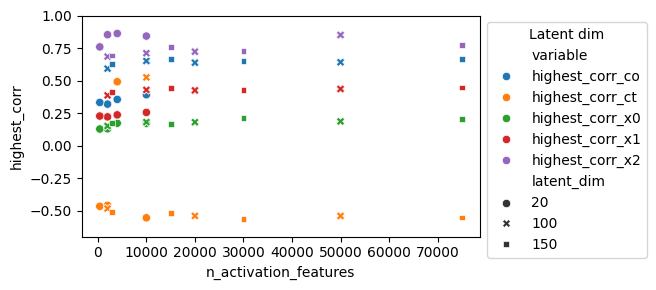

In [42]:
# plot the variable against n_activation_features and color by latent dim
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
sns.scatterplot(data=metrics_corr, x='n_activation_features', y='highest_corr', style='latent_dim', hue='variable')
plt.ylim(-0.7, 1.0)
#plt.xscale('log')
plt.tight_layout()
plt.legend(title='Latent dim', loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

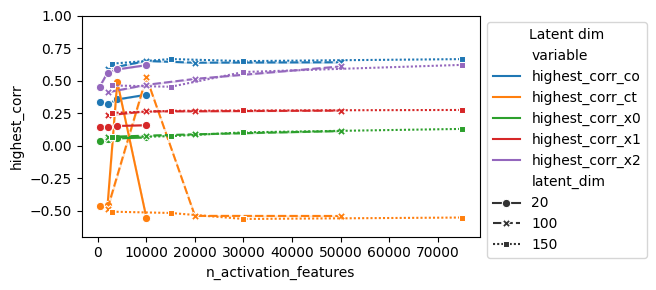

In [33]:
# plot the variable against n_activation_features and color by latent dim
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
sns.lineplot(data=metrics_corr, x='n_activation_features', y='highest_corr', hue='variable', style='latent_dim', markers=True)
plt.ylim(-0.7, 1.0)
plt.tight_layout()
plt.legend(title='Latent dim', loc='upper left', bbox_to_anchor=(1, 1))
plt.show()